# pyfixp: Fast Fixpoint Quantization and Overflow in Python #
This notebook shows how to use the ``pyfixp`` library to represent fixpoint numbers in binary format and how to (re-)quantize them. `pyfixp` is based on numpy and aims to be a fast library for fixpoint arithmetics.

Most static images don't show in github HTML at the moment (09/2020). Running the notebook locally works as well as the Notebook Viewer at https://nbviewer.jupyter.org/. Simply copy and paste the URL of this notebook.

In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

import pyfixp.pyfixp as fx
print("pyfixp version = ", fx.__version__)
%matplotlib inline    

import matplotlib.pyplot as plt

plt.style.use('script.mplstyle')
import numpy as np
import scipy.signal as sig

figsize = {"figsize":(13,7)}

pyfixp version =  0.9.1


## Two's Complement Number Representation ##

Unsigned numbers are currently not supported by this library.

The next figure shows how signed integer numbers are represented in two's complement format. The MSB is the sign bit which can be interpreted as the negative value $-2^{W-1}$.
<figure>
    <center>
    <img src='img/twos_complement_signed_int.png' alt='Signed integers in twos complement' width='40%'/>
    <figcaption><b>Fig. x:</b> Signed integers in twos complement</figcaption>
    </center>
</figure>

The same is possible for signed fractional values, although it is important to realize that the *binary point only exists in the developer's head*!  All arithmetic stuff can be implemented with "integer thinking" (and some designers just do that). IMHO, thinking in fractional numbers makes it easier to track the real world value and to separate the range and the resolution.
 
<figure>
    <center>
    <img src='img/twos_complement_signed_frac.png' alt='Signed fractional values in twos complement' width='50%'/> 
    <figcaption><b>Fig. x:</b> Signed fractional values in twos complement</figcaption>
   </center>
 </figure>


### Increasing the wordlength

Before adding two fixpoint numbers their binary points need to be aligned, i.e. they need to have the same number of integer and fractional bits. This can be achieved by extending integer and / or fractional part. 

The value of a fixpoint number doesn't change when zeros are appended to the fractional part (for positive and negative numbers) so that part is easy. 

Prepending zeros to the integer part would change the sign of a negative number. Instead, the integer part is extended with copies of the sign bit, also called **sign extension**. VHDL has the function ``SEXT(std_log_vect, int)`` for achieving this.

<img src="img/requant_extension.png" alt="Extnd integer and fractional part" width="40%"/> 

### Reducing the number of fractional bits

The problem of reducing the number of fractional places is well known from the decimal system. Different methods have been developed to achieve this like rounding, truncation, see e.g. https://www.eetimes.com/an-introduction-to-different-rounding-algorithms for more details than you'll ever need.
 
<figure>
    <img src='img/requant_reduce_fractional.png' alt='Reduce fractional word length' width='80%'/>
    <figcaption>Fig. x: Reduction of fractional wordlength</figcaption>
</figure>

## pyfixp

This section describes how to use the fixpoint library `pyfixp` in detail. A quantizer is constructed as an instance of the class `Fixed()`, its properties are configured with a quantization dict `Q = fx.Fixed(q_dict)`. The quantization dict (in this case `q_dict`) sets the format `QI.QF` at the output of the quantizer and its quantization and overflow behaviour with the following keys:

- **'WI'**   : number of integer bits (integer)
- **'WF'**   : number of fractional bits (integer)
- **'quant'**: requantization behaviour (**'floor'**, 'round', 'fix', 'ceil', 'rint', 'none')
- **'ovfl'** : overflow behaviour (**'wrap'**, 'sat', 'none')
- **'frmt'** : number base / format for output (**'float'**, 'dec', 'bin', 'hex', 'csd'). Non-floats are scaled with 'scale'
- **'scale'**: float or a keyword; the factor between the fixpoint integer representation (FXP) and the real world value (RWV), RWV = FXP / scale. By default, scale = 1 << WI.  If ``scale`` is a float, this value is used. 

     **Examples:**
    
     ```
     WI.WF = 3.0, FXP = "b0110." = 6,   scale = 8 -> RWV = 6 / 8   = 0.75
     WI.WF = 1.2, FXP = "b01.10" = 1.5, scale = 2 -> RWV = 1.5 / 2 = 0.75
     ```
     
     Alternatively, if:

     - ``q_obj['scale'] == 'int'``:   `scale = 1 << self.WF`

     - ``q_obj['scale'] == 'norm'``:  `scale = 2.**(-self.WI)`      


`?fx.Fixed` shows the available options.

### Example
In the following example a quantizer is defined with an output format of 0 integer bits and 3 fractional bits, overflows are wrapped around in two's complement style and additional fractional bits are simply truncated ("floor").

In [2]:
q_dict = {'WI':0, 'WF': 3,                 # number of integer and fractional bits
          'quant':'floor', 'ovfl': 'wrap'} # quantization and overflow behaviour
Q = fx.Fixed(q_dict)                       # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1:>5.3f}".format(i, Q.fixp(i))) # quantize i
# uncomment to show documentation
# ?fx.Fixed 

q<0.00> = 0.000
q<0.10> = 0.000
q<0.20> = 0.125
q<0.30> = 0.250
q<0.40> = 0.375
q<0.50> = 0.500
q<0.60> = 0.500
q<0.70> = 0.625
q<0.80> = 0.750
q<0.90> = 0.875
q<1.00> = -1.000
q<1.10> = -1.000


### Signal Quantization
A sine signal $s(t)$ is quantized in the code below. The plot shows $s(t)$, the quantized signal $s_Q(t)$ and the difference between both signals, the quantization error $\epsilon(t)$.

Overflows:	2200
Run time:	1.01 ms for 10000 quantizations



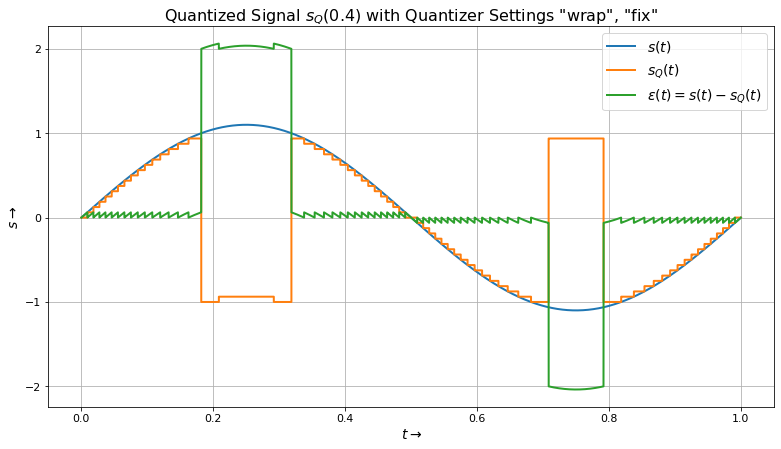

In [3]:
N = 10000; f_a = 1
t = np.linspace(0, 1, N, endpoint=False)
s = 1.1 * np.sin(2 * np.pi * f_a * t)
#
q_dict = {'WI':0, 'WF': 4, 'quant':'fix', 'ovfl': 'wrap'} # also try 'round' ; 'sat'
Q = fx.Fixed(q_dict) # quantizer instance with parameters defined above

t_cpu = time.perf_counter()

sq = Q.fixp(s) # quantize s
print('Overflows:\t{0}'.format(Q.N_over))
print('Run time:\t{0:.3g} ms for {1} quantizations\n'.format((time.perf_counter()-t_cpu)*1000, Q.N_data))
#
fig1, ax1 = plt.subplots(**figsize)
ax1.set_title('Quantized Signal $s_Q$({0}.{1}) with Quantizer Settings "{2}", "{3}"'.format(Q.WI, Q.WF, Q.ovfl, Q.quant))
ax1.plot(t, s, label = r'$s(t)$', lw=2)
ax1.step(t, sq, where = 'post', label = r'$s_Q(t)$', lw=2)
ax1.plot(t, s-sq, label = r'$\epsilon(t) = s(t) - s_Q(t)$', lw=2)
ax1.legend(fontsize = 14)
ax1.grid(True)
ax1.set_xlabel(r'$t \rightarrow$'); ax1.set_ylabel(r'$s \rightarrow$');
#

### Transfer Function of the Quantizer
The transfer function of the quantizer shows the quantized signal $s_Q(t)$ over the input signal $s(t)$ (a ramp). The advantage over reusing the sine from the previous cell is that the input range can be taylored more easily and that the step size is constant.

Overflows:	4844


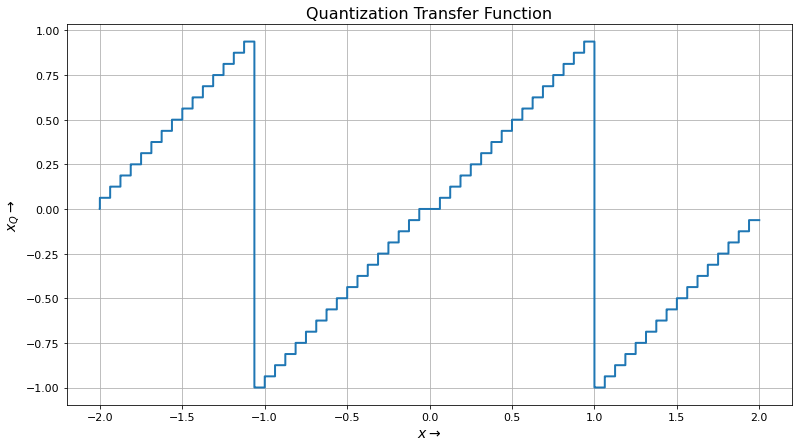

In [4]:
Q.resetN()    # reset overflow counter
x = np.linspace(-2, 2, N, endpoint=False) # generate ramp signal
xq = Q.fixp(x) # quantize x
print('Overflows:\t{0}'.format(Q.N_over))
fig2, ax2 = plt.subplots(**figsize); ax2.grid(True)
ax2.set_title('Quantization Transfer Function')
ax2.step(x,xq, where = 'post')
ax2.set_xlabel(r'$x \rightarrow$'); ax2.set_ylabel(r'$x_Q \rightarrow$');

### Number bases and formats
Quantized values can be printed in different number bases, e.g. as a binary string:

In [5]:
q_dict_f = {'WI':0, 'WF': 8,               # number of ingeger and fractional bits
          'quant':'floor', 'ovfl': 'wrap', # quantization and overflow behaviour
          'frmt':'bin'}                    # output format
Q1 = fx.Fixed(q_dict_f)                    # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1}".format(i, Q1.float2frmt(Q1.fixp(i)))) # quantize i + display it in the wanted format

q<0.00> = 0.00000000
q<0.10> = 0.00011001
q<0.20> = 0.00110011
q<0.30> = 0.01001100
q<0.40> = 0.01100110
q<0.50> = 0.10000000
q<0.60> = 0.10011001
q<0.70> = 0.10110011
q<0.80> = 0.11001100
q<0.90> = 0.11100110
q<1.00> = 1.00000000
q<1.10> = 1.00011001


### Format Conversion
Fixpoint numbers can also be converted back to floating point with the method `frmt2float()`:

In [6]:
Q0 = fx.Fixed({'Q':'3.8', 'quant':'round', 'ovfl':'wrap', 'frmt':'bin'}) # direct setting of quantization options, use 'Q' instead of 
Q1_dict = Q0.q_obj        # read out Q0 quantization dict
Q1_dict.update({'WI':1, 'WF':5})  # update dict
Q1 = fx.Fixed(Q1_dict)    # and create a new quantizer instance with it      
frmt_str = "0.011"
x_org = Q0.frmt2float(frmt_str)
x_q = Q1.frmt2float(frmt_str)
print("q<b{0}> = {1} -> b{2} = {3}".format(frmt_str, x_org, Q1.float2frmt(x_q), x_q))

q<b0.011> = 0.375 -> b00.01100 = 0.375


Bug ?: Illegal characters in the string to be formatted (e.g. frmt2float("0.0x11") do not raise an error but are ignored.

## FIR Filters

The following cell designs an equiripple filter and plots its impulse response (same as the coefficients) and its magnitude frequency response.

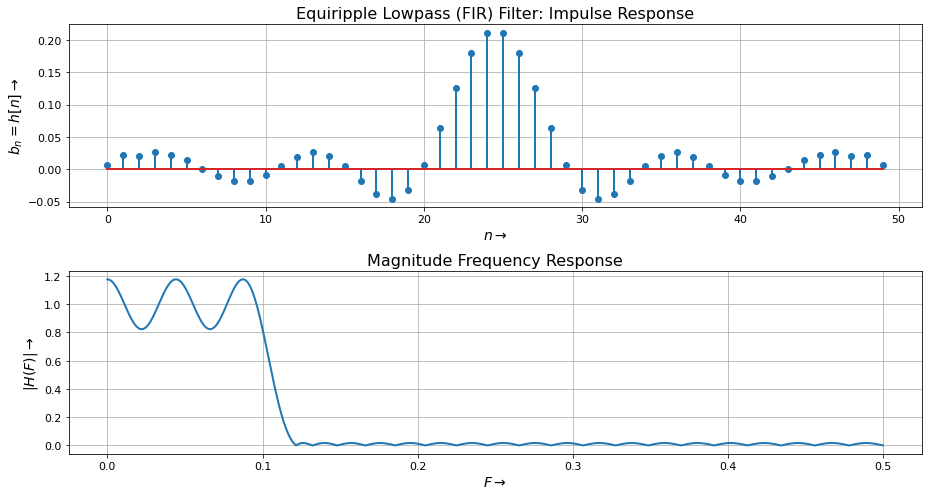

In [14]:
numtaps = 50 # filter order
N_FFT = 2000 # number of frequency bins per half plane
b = sig.remez(numtaps,[0,0.1,0.12, 0.5], [1,0], [1,10]) # frequency bands, target amplitude, weights
w, h = sig.freqz(b, [1], worN=N_FFT)
f = w / (2*np.pi)
fig, (ax1, ax2) = plt.subplots(2, **figsize); ax1.grid(True); ax2.grid(True)
ax1.set_title('Equiripple Lowpass (FIR) Filter: Impulse Response')
ax1.stem(np.arange(numtaps), b, use_line_collection=True)
ax1.set_xlabel(r'$n \rightarrow$'); ax1.set_ylabel(r'$b_n = h[n] \rightarrow$')
ax2.set_title('Magnitude Frequency Response')
ax2.plot(f,np.abs(h))
ax2.set_xlabel(r'$F \rightarrow$'); ax2.set_ylabel(r'$|H(F)| \rightarrow$')
fig.set_tight_layout(True)

Fixpoint filters process quantized input data (quantizer $Q_X$ in the image below), have quantized coeffients, a maximum accumulator width ($Q_A$) and a quantized output ($Q_Y$). Fig xx shows the topology of a direct form FIR filter.
<figure>
   <center>
    <img src='img/fir_df.png' alt='Direct Form FIR Filter' width='30%'/>
    <figcaption><b>Fig. x:</b> Direct Form FIR Filter</figcaption>
   </center>
</figure>
Due to the non-linear effects of quantization, fixpoint filters can only be simulated in the time domain, taking the filter topology into account. 


Fixpoint filters process quantized input data (quantizer $Q_X$ in the image above), have quantized coeffients, a maximum accumulutator width ($Q_A$) and a quantized output ($Q_Y$).

[ 0.         0.015625   0.015625   0.0234375  0.015625   0.0078125
  0.        -0.015625  -0.0234375 -0.0234375 -0.015625   0.
  0.015625   0.0234375  0.015625   0.        -0.0234375 -0.0390625
 -0.046875  -0.03125    0.         0.0625     0.125      0.1796875
  0.2109375  0.2109375  0.1796875  0.125      0.0625     0.
 -0.03125   -0.046875  -0.0390625 -0.0234375  0.         0.015625
  0.0234375  0.015625   0.        -0.015625  -0.0234375 -0.0234375
 -0.015625   0.         0.0078125  0.015625   0.0234375  0.015625
  0.015625   0.       ]
50
[ 0.00632975  0.02189096  0.02063926  0.02618112  0.02213525  0.01376241
  0.00117795 -0.01088422 -0.01821588 -0.01750242 -0.00842093  0.00590476
  0.01962519  0.02623707  0.02128806  0.00469337 -0.0184089  -0.03873033
 -0.04566575 -0.03118868  0.0068904   0.06325331  0.12603738  0.17997998
  0.21111289  0.21111289  0.17997998  0.12603738  0.06325331  0.0068904
 -0.03118868 -0.04566575 -0.03873033 -0.0184089   0.00469337  0.02128806
  0.02623707  0.

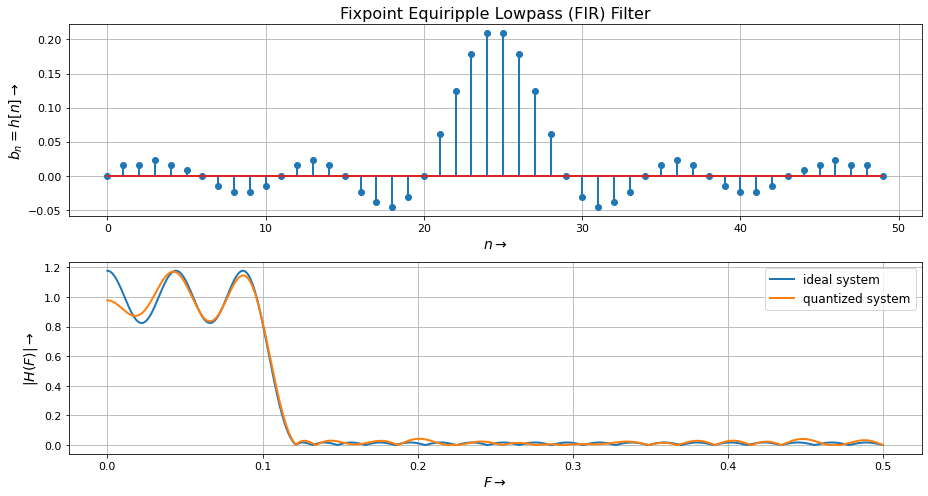

In [24]:
from pyfixp.filters.fir_df import FIR_DF

q_bxy = {'WI':0, 'WF': 7, 'quant':'floor', 'ovfl': 'sat'} # quantization dict for x, q and coefficients
q_accu = {'WI':0, 'WF': 15, 'quant':'floor', 'ovfl': 'wrap'} # ... for accumulator
Q_X = fx.Fixed(q_bxy); Q_Y = fx.Fixed(q_bxy)
Q_b = fx.Fixed(q_bxy); Q_accu = fx.Fixed(q_accu)
bq = Q_b.fixp(b) # quantized coefficients
print(bq)
print(len(bq))
print(b)

fil_q = FIR_DF(bq, q_accu) # optional: Fix_FIR_DF(q_accu, q_mul) with requantization after each multiplier
x = np.zeros(120); x[0] = 1 
xq = Q_X.fixp(x);
yq = fil_q.fxfilter(None, xq)
#yq = Q_Y.fixp(fil_q.filt(xq,bq)) # this modifies bq?!
fig, (ax1, ax2) = plt.subplots(2, **figsize); ax1.grid(True); ax2.grid(True)
ax1.set_title('Fixpoint Equiripple Lowpass (FIR) Filter')
ax1.stem(np.arange(numtaps), yq[:numtaps], use_line_collection=True)
ax1.set_xlabel(r'$n \rightarrow$'); ax1.set_ylabel(r'$b_n = h[n] \rightarrow$')
ax2.plot(f,np.abs(h), label="ideal system")
ax2.plot(f, np.abs(np.fft.rfft(yq, 2*N_FFT)[:-1]), label = "quantized system")
ax2.set_xlabel(r'$F \rightarrow$'); ax2.set_ylabel(r'$|H(F)| \rightarrow$')
ax2.legend()
fig.set_tight_layout(True)

## IIR Filters
Unlike FIR filters, IIR filters cannot be implemented with the same elegance and efficiency of array mathematics as each sample depends on the output sample as well. The following code cell designs an elliptic low pass filter and plots its magnitude frequency response.

The topology of fixpoint IIR filters is much more important for its performance than for FIR filters. It can make a large difference for IIR filters in which order recursive and transversal part of the filter are calculated (direct form 1 vs. direct form 2) which is not the case for ideal systems.

b= [ 0.01967691 -0.01714282  0.03329653 -0.01714282  0.01967691]
a= [ 1.         -3.03302405  3.81183153 -2.29112937  0.5553678 ]


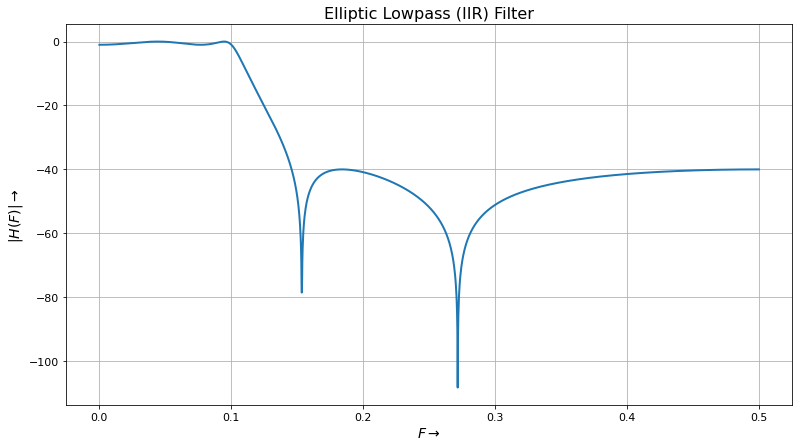

In [9]:
b,a = sig.ellip(4,1,40, 2*0.1) # order, pass band ripple, stop band ripple, corner frequency w.r.t. f_S/2
w, h = sig.freqz(b,a, worN=2000)
fig, ax = plt.subplots(1, **figsize); ax.grid(True)
ax.set_title('Elliptic Lowpass (IIR) Filter')
ax.plot(w / (2*np.pi),20*np.log10(np.abs(h)))
ax.set_xlabel(r'$F \rightarrow$'); ax.set_ylabel(r'$|H(F)| \rightarrow$')
print("b=", b)
print("a=", a)

<figure>
     <center>
    <img src='img/iir_df1_df2.png' alt='Direct Form IIR Filter' width='60%'/>
    <figcaption><b>Fig. x:</b> Direct Form FIR Filter Type 1 and 2</figcaption>
 </center>
</figure>

The following two examples show how to implement the most simple recursive filters (no transversal path, i.e. "all-pole filters") and test them.

In [10]:
def IIR1(Q_ACCU, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-1] + a y[i-1] >
    """
    y = np.zeros(len(x))
    for i in range(0,len(x)-1):
        y[i+1] = Q_ACCU.fixp(x[i] + a * y[i])
    return y
    
def IIR2(Q_ACCU, x, a):
    """
    Rekursives Filter mit y[i] = Q< x[i-2] + y[i-1] - a y[i-2] >
    """
    y = np.zeros(len(x))
    for i in range(len(x)-2):
        y[i+2] = Q_ACCU.fixp(x[i] + y[i+1] - y[i]*a)
    return y

Quantization and overflows in IIR-filters can create so called "zero-input limit cycles", i.e. there is a constant or periodic signal at the filter output although the input signal has been turned off.

- **Small scale limit cycles** can result when the absolute signal value grows during requantization (energy is added). This can happen (depending on the sign) with `'round'` und `'floor'` auftreten. With the `'fix'` setting, the magnitude never grows, avoiding limit cycles. To see some small scale limit cycles, try the IIR1 filter with the settings
`alpha = +/-0.9` and `q_accu = {'Q':(0,4),'quant':'round','ovfl':'sat'}`

- **Large scale limit cycles** can be triggered by overflows. Saturation logic prevents this kind of overflow. To see some large scale limit cycles, try the IIR2 filter with the following settings
`alpha = +0.9`, `x[0] = 1` and `q_accu = {'Q':(0,4),'quant':'round','ovfl':'wrap'}`

Try out the settings `'floor'` and `'sat'` as well to test their impact on limit cycle creation.

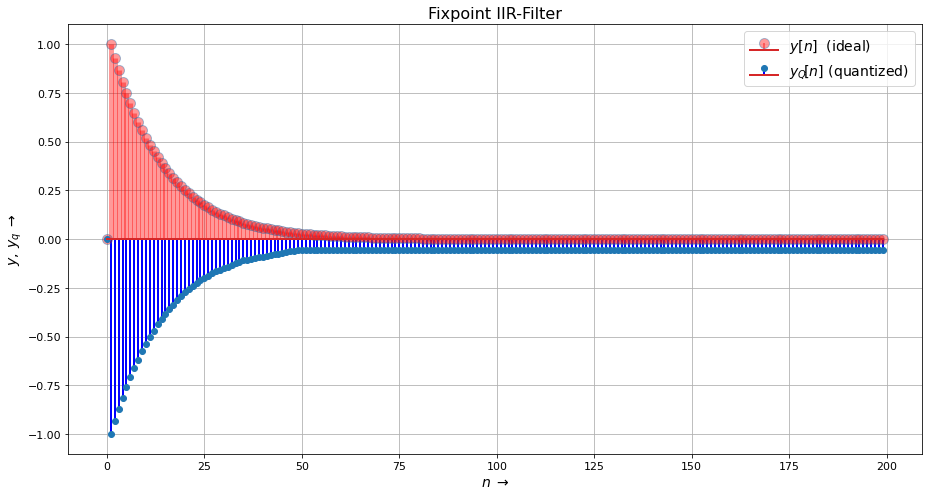

In [11]:
alpha = 0.93 # coefficient
N_sim = 200 # number of simulation steps
x = np.zeros(N_sim); x[0] = 1.0 # x is dirac pulse with weight 1
 
q_x = {'WI':0,'WF':3,'quant':'round','ovfl':'sat'} # fixpoint quantization for stimulus
q_coeff = {'WI':0,'WF':3,'quant':'round','ovfl':'wrap'} # coefficient quantization dict
# quantizer settings for accumulator
#q_accu = {'WI':0,'WF':4,'quant':'fix','ovfl':'sat'} # saturation and round towards zero -> no limit cycles
q_accu = {'Q':0.8,'quant':'floor','ovfl':'wrap'}  # 'floor' and 'wrap': large scale limit cy^cles for  QI = 0
# kleine Grenzzyklen mit round / floor, abhängig von alpha:
# q_accu = {'WI':0,'WF':4,'quant':'floor','ovfl':'wrap'} 

# Keine Quantisierung ->  Werte für I, F beliebig
q_ideal = {'WI':0,'WF':0,'quant':'none','ovfl':'none'}

Q_coeff = fx.Fixed(q_coeff) # Fixpoint Object with parameters "q_coeff"

Q_ideal = fx.Fixed(q_ideal) # Fixpoint object without quantisation and overflow 
Q_accu = fx.Fixed(q_accu) # Fixpoint object defined by dictionary "q_accu"

n = np.arange(N_sim)
t1 = time.perf_counter()
alpha_q = Q_ideal.fixp(alpha)

y = IIR1(Q_ideal, x, alpha_q) # no quantization
yq = IIR1(Q_accu, x, alpha_q)
#yq = IIR2(Q_accu, x, alpha_q)


fig1, ax1 = plt.subplots(**figsize); ax1.grid(True)
ax1.set_title('Fixpoint IIR-Filter')

mly, sly, bly = ax1.stem(n,y, label = r'$y[n]\;$ (ideal)', use_line_collection=True)
plt.setp(mly, 'markerfacecolor', 'r', 'markersize', 10 ,'alpha', 0.4) # markerline
plt.setp(sly, 'color','r', 'linewidth', 5, 'alpha', 0.4) # stemline
ax1.stem(n, yq, 'b', label = r'$y_Q\![n]$ (quantized)', use_line_collection=True)
ax1.legend(fontsize = 14); 
ax1.set_xlabel(r'$n \; \rightarrow$')
ax1.set_ylabel(r'$y,\, y_q \; \rightarrow$')
#
fig1.set_tight_layout(True)

***
### Copyright

(c) 2016 - 2020 Christian Münker 

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources) , feel free to use it for your own purposes. Please attribute the work as follows: *Christian Münker, pyfixp documentation*.